# Recurrent Neural Networks

In this notebook we"re going to explore handwritten digit recognition task using MNIST database and different RNN approaches

In [1]:
import time

import numpy as np
import pandas as pd

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Convolution2D, MaxPooling2D, Reshape
from keras.utils.np_utils import to_categorical
from keras import backend as K
from keras.utils.vis_utils import model_to_dot

from IPython.display import SVG

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


Set style

In [2]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["figure.figsize"] = (10, 8)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

Just for the sake of reproducibility

In [3]:
np.random.seed(41)

# Data

In this tutorial we"re going to use MNIST dataset with handwritten digits.

## MNIST overview

Let"s download MNIST dataset. There is a special function in Keras for that purpose (because MNIST is extremely popular)

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(len(X_train), "train samples")
print(len(X_test), "test samples")

60000 train samples
10000 test samples


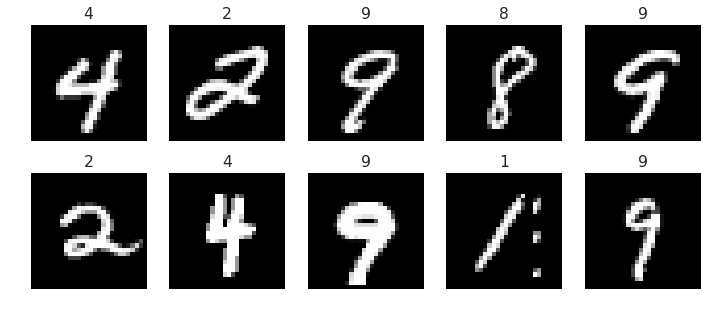

In [5]:
plt.figure(figsize=(12, 5))
for num, i in enumerate(np.random.choice(len(X_train), 10)):
    plt.subplot(2, 5, num + 1)
    plt.imshow(X_train[i], cmap="Greys_r")
    plt.axis("off")
    plt.title(str(y_train[i]))

Let"s see objects are distributed among classes

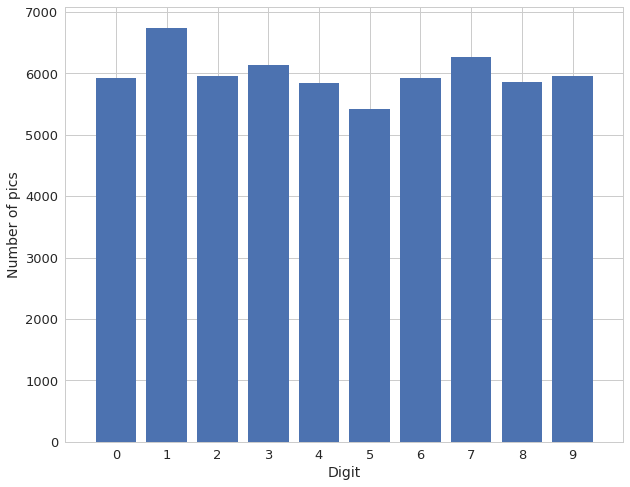

In [6]:
x_bars, y_bars = np.unique(y_train, return_counts=True)
plt.bar(x_bars, y_bars)
plt.xlim([-1, 10])
plt.xticks(np.arange(0, 10))
plt.xlabel("Digit", fontsize=14)
plt.ylabel("Number of pics", fontsize=14);

As one can see, the task is pretty balanced

## Data preparation

First of all, let"s predefine image parameters:
* **img_rows, img_cols** $-$ 2D dimension of a pictures; for MNIST it is $28 \times 28$
* **nb_classes** $-$ number of classes (digits in our case)

In [7]:
img_rows, img_cols = 28, 28
nb_classes = 10

Theano and Tensorflow both are tensor-based libraries. It means that all objects inside it, all inputs and outputs are **tensors**. One can treat tensor as a simple multidimensional array.

Tensorflow prefers to work with $\text{float32}$ data type. So the next step is to cast data. Also let"s have our data in $[0; 1]$ interval $-$ it"s common choice for grayscale images.

In [8]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255

Last step is to convert labels into [One-Hot Encoding](https://en.wikipedia.org/wiki/One-hot) because we"re going to learn them through the softmax layer of RNN

In [9]:
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

# Dense baseline model

First of all, let"s build MLP model and see how it performs

In [10]:
model_dense = Sequential()

In [11]:
model_dense.add(Dense(128, input_shape=(img_rows * img_cols,), activation="relu"))
model_dense.add(Dropout(0.5))
model_dense.add(Dense(128, activation="relu"))
model_dense.add(Dropout(0.5))
model_dense.add(Dense(128, activation="relu"))
model_dense.add(Dropout(0.5))
model_dense.add(Dense(nb_classes, activation="softmax"))

Our model the the following architercture

In [12]:
model_dense.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total para

Compile model

In [13]:
model_dense.compile(loss="categorical_crossentropy",
                    optimizer="adam",
                    metrics=["accuracy"])

## Training

In [14]:
%%time
start_time_dense = time.time()
hist = model_dense.fit(X_train.reshape((-1, img_cols * img_rows)), y_train, 
                       validation_data = (X_test.reshape((-1, img_cols * img_rows)), y_test), 
                       epochs=5, batch_size=128)
end_time_dense = time.time()

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 3s - loss: 0.8000 - acc: 0.7393 - val_loss: 0.2267 - val_acc: 0.9345
Epoch 2/5
60000/60000 [==============================] - 2s - loss: 0.3616 - acc: 0.8995 - val_loss: 0.1588 - val_acc: 0.9531
Epoch 3/5
60000/60000 [==============================] - 2s - loss: 0.2984 - acc: 0.9180 - val_loss: 0.1438 - val_acc: 0.9612
Epoch 4/5
60000/60000 [==============================] - 2s - loss: 0.2547 - acc: 0.9304 - val_loss: 0.1332 - val_acc: 0.9637
Epoch 5/5
60000/60000 [==============================] - 2s - loss: 0.2336 - acc: 0.9364 - val_loss: 0.1217 - val_acc: 0.9654
CPU times: user 20.5 s, sys: 4.59 s, total: 25.1 s
Wall time: 12.9 s


## Evaluation

Learning process visualization

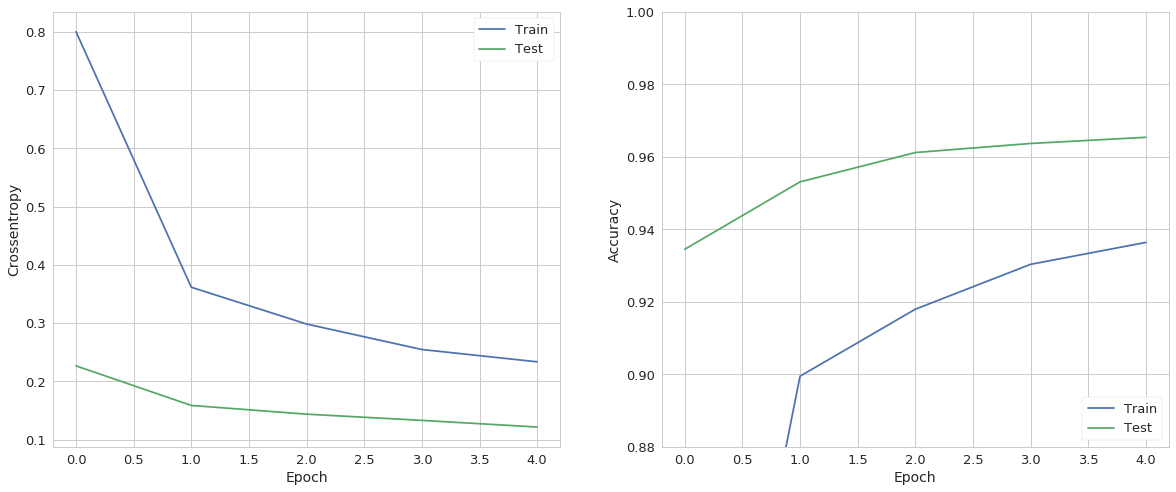

In [15]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.plot(hist.history["loss"], label="Train")
plt.plot(hist.history["val_loss"], label="Test")
plt.grid("on")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Crossentropy", fontsize=14)
plt.legend(loc="upper right")

plt.subplot(122)
plt.plot(hist.history["acc"], label="Train")
plt.grid("on")
plt.plot(hist.history["val_acc"], label="Test")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(loc="lower right")
plt.ylim([0.88, 1.0]);

Table to store the results of the experiments

In [16]:
score_train = model_dense.evaluate(X_train.reshape((-1, img_cols * img_rows)), y_train, verbose=0)
score_test = model_dense.evaluate(X_test.reshape((-1, img_cols * img_rows)), y_test, verbose=0)

In [17]:
results = pd.DataFrame(columns=["Accuracy Train, %", "Accuracy Test, %", "Loss Train", "Loss Test", "Time, s"])
results.loc[len(results)] = np.array([np.round(score_train[1] * 100, 2), 
                                      np.round(score_test[1] * 100, 2), 
                                      np.round(score_train[0], 3), 
                                      np.round(score_test[0], 3), 
                                      np.round(end_time_dense - start_time_dense, 1)])
results.index = ["MLP"]

In [18]:
results

,"Accuracy Train, %","Accuracy Test, %",Loss Train,Loss Test,"Time, s"
MLP,97.05,96.54,0.101,0.122,12.9


# Columnwise Recurrent model

Here we"re going to use the following approach:
* Treat the picture as a sequence of vectors
* Each vector is a column of pixels from the initial picture
* Apply recurrent neural net to classify sequences

## One-layer LSTM

Let"s build the simplest recurrent network with one hidden LSTM layer. Note that the order of dimensions is the same for the whole recurrent layers in Keras and is the following: $(\text{batch_size}, \text{timesteps}, \text{input_dim})$. Here we have columns as timesteps and rows inside one column as a features.

In [19]:
inp = Input(shape=(img_cols, img_rows))

Now Let"s add LSTM layer which works in the "Many-to-One" fashion. It means that the layer outputs only the last generated value. `return_sequences` parameter is responsible for this option.

<img src="many_to_one.png">

In [20]:
hid = LSTM(units=16, return_sequences=False)(inp)

Let"s stack fully-conected classifier on top of that:

In [21]:
hid = Dense(units=32, activation="relu")(hid)
hid = Dropout(rate=0.5)(hid)
out = Dense(nb_classes, activation="softmax")(hid)

In [22]:
model_column_onelayer = Model(inputs=[inp], outputs=[out])

The final layer here uses $\text{softmax}$ activation function with the number of classes. So as the output of the network we observe the probability of each class.

Now let"s compile our model.
* **optimizer** $-$ here we use `Adam` accelerated gradient descent algorithm with special adaptive way of choosing learning rate; for more details see this great [overview](http://sebastianruder.com/optimizing-gradient-descent/) of gradient descent optimization algorithms.
* **loss** $-$ usual choice for multiclass classification is softmax output layer in combination with categotical crossentropy loss function which is
$$
\mathcal{L}(\text{true}, \text{pred}) = -\sum_{j=1}^{\text{n_cl}}\text{true}_j \cdot \log \{\text{pred}_j\}
$$
* **metrics** $-$ additional metrics that we"re going to trace while training; it doesn"t influence training process at all

In [23]:
model_column_onelayer.compile(loss="categorical_crossentropy", 
                              optimizer="adam", 
                              metrics=["accuracy"])

Let"s take a look at our final model now:

In [24]:
model_column_onelayer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                2880      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                544       
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
Total params: 3,754
Trainable params: 3,754
Non-trainable params: 0
_________________________________________________________________


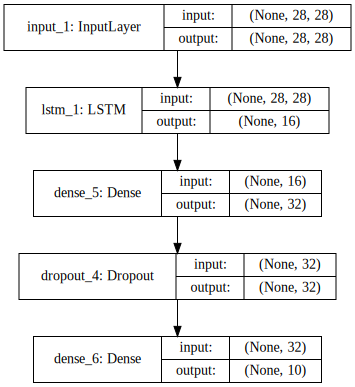

In [25]:
SVG(model_to_dot(model_column_onelayer, show_shapes=True).create(prog="dot", format="svg"))

Training parameters are the following:
* epochs $-$ number of epochs to train. here we choose 12; one may condiser using some stopping criterias
* **batch_size** $-$ parameter that controls how frequent do we update gradient; with $\text{batch_size}=1$ optimization is nothing but pure Stohastic Gradient Descent (update gradient after passing each one object); with $\text{batch_size}=\textit{number of objects}$ it will be usual Gradient Descent which updates gradient only after passing all objects. Choosing value between this two one can control speed and convergence of training process.

In [26]:
batch_size = 128
epochs = 5

Train!

In [27]:
%%time
start_time_column_onelayer = time.time()
hist_column_onelayer = model_column_onelayer.fit(X_train, y_train, 
                                                 batch_size=batch_size, 
                                                 epochs=epochs,
                                                 validation_data=(X_test, y_test))
end_time_column_onelayer = time.time()

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 27s - loss: 1.5661 - acc: 0.4510 - val_loss: 0.8493 - val_acc: 0.7301
Epoch 2/5
60000/60000 [==============================] - 26s - loss: 0.8686 - acc: 0.7177 - val_loss: 0.5489 - val_acc: 0.8280
Epoch 3/5
60000/60000 [==============================] - 26s - loss: 0.6658 - acc: 0.7947 - val_loss: 0.4362 - val_acc: 0.8634
Epoch 4/5
60000/60000 [==============================] - 26s - loss: 0.5704 - acc: 0.8277 - val_loss: 0.3712 - val_acc: 0.8863
Epoch 5/5
60000/60000 [==============================] - 27s - loss: 0.5135 - acc: 0.8509 - val_loss: 0.3250 - val_acc: 0.9000
CPU times: user 3min 43s, sys: 29.2 s, total: 4min 12s
Wall time: 2min 15s


Visualization of learning process:

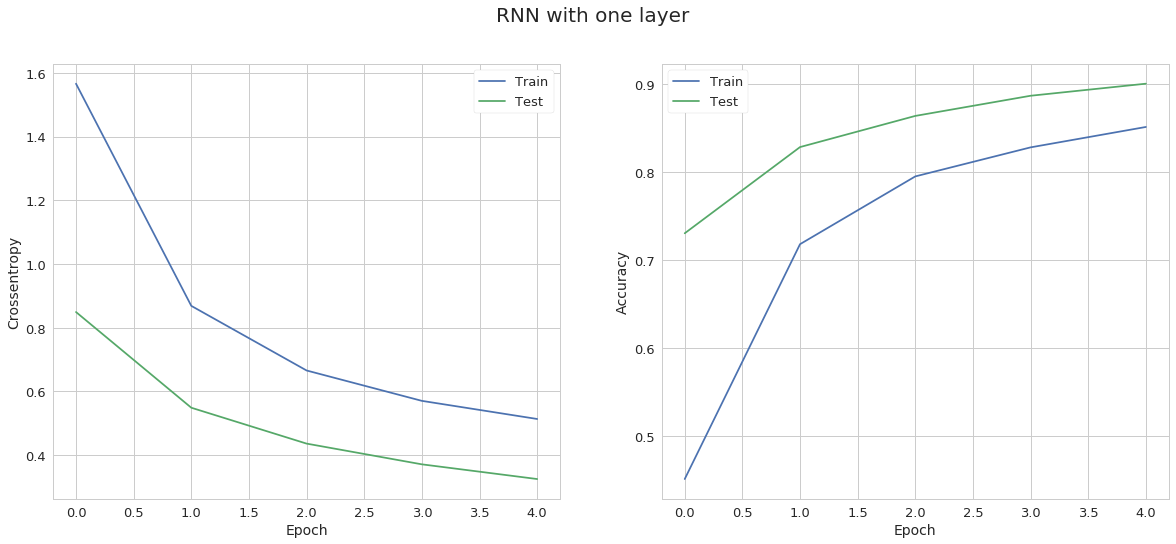

In [28]:
plt.figure(figsize=(20, 8))
plt.suptitle("RNN with one layer", fontsize=20)

plt.subplot(121)
plt.plot(hist_column_onelayer.history["loss"], label="Train")
plt.plot(hist_column_onelayer.history["val_loss"], label="Test")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Crossentropy", fontsize=14)
plt.legend()

plt.subplot(122)
plt.plot(hist_column_onelayer.history["acc"], label="Train")
plt.plot(hist_column_onelayer.history["val_acc"], label="Test")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend();

Final evaluation of the model:

In [29]:
score_train = model_column_onelayer.evaluate(X_train, y_train, verbose=0)
score_test = model_column_onelayer.evaluate(X_test, y_test, verbose=0)

In [30]:
results.loc[len(results)] = np.array([np.round(score_train[1] * 100, 2), 
                                      np.round(score_test[1] * 100, 2), 
                                      np.round(score_train[0], 3), 
                                      np.round(score_test[0], 3), 
                                      np.round(end_time_column_onelayer - start_time_column_onelayer, 1)])
results.index = ["MLP", "LSTM 1L"]

In [31]:
results

,"Accuracy Train, %","Accuracy Test, %",Loss Train,Loss Test,"Time, s"
MLP,97.05,96.54,0.101,0.122,12.9
LSTM 1L,89.93,90.00,0.330,0.325,136.0


## Two-layers LSTM

Now let"s try deeper LSTM

In [32]:
inp = Input(shape=(img_cols, img_rows))

Now last layer will also be running in the "Many-to-One" fashion. But the intermediate LSTM layer should outputs the values at each step to make the following LSTM works on the sequence. This manner is called "Many-to-Many"

<img src="many_to_many2.png">

In [33]:
hid = LSTM(units=16, return_sequences=True)(inp)
hid = LSTM(units=16, return_sequences=False)(hid)

Let"s stack fully-conected classifier on top of that:

In [34]:
hid = Dense(units=32, activation="relu")(hid)
hid = Dropout(rate=0.5)(hid)
out = Dense(nb_classes, activation="softmax")(hid)

In [35]:
model_column_twolayers = Model(inputs=[inp], outputs=[out])

The final layer here uses $\text{softmax}$ activation function with the number of classes. So as the output of the network we observe the probability of each class.

In [36]:
model_column_twolayers.compile(loss="categorical_crossentropy", 
                               optimizer="adam", 
                               metrics=["accuracy"])

Let"s take a look at our final model now:

In [37]:
model_column_twolayers.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 28, 16)            2880      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                544       
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                330       
Total params: 5,866
Trainable params: 5,866
Non-trainable params: 0
_________________________________________________________________


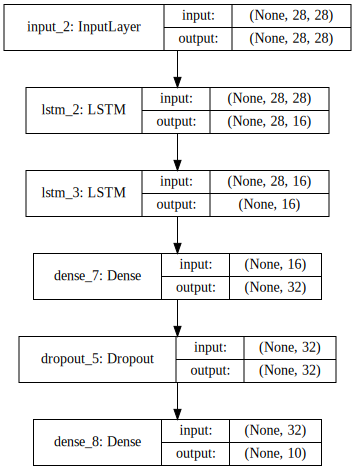

In [38]:
SVG(model_to_dot(model_column_twolayers, show_shapes=True).create(prog="dot", format="svg"))

In [39]:
batch_size = 128
epochs = 5

Train!

In [40]:
%%time
start_time_column_twolayers = time.time()
hist_column_twolayers = model_column_twolayers.fit(X_train, y_train, 
                                                   batch_size=batch_size, 
                                                   epochs=epochs,
                                                   validation_data=(X_test, y_test))
end_time_column_twolayers = time.time()

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 45s - loss: 1.4005 - acc: 0.5134 - val_loss: 0.6121 - val_acc: 0.8044
Epoch 2/5
60000/60000 [==============================] - 44s - loss: 0.6729 - acc: 0.7913 - val_loss: 0.3793 - val_acc: 0.8876
Epoch 3/5
60000/60000 [==============================] - 45s - loss: 0.4997 - acc: 0.8541 - val_loss: 0.2919 - val_acc: 0.9162
Epoch 4/5
60000/60000 [==============================] - 45s - loss: 0.4096 - acc: 0.8871 - val_loss: 0.2365 - val_acc: 0.9309
Epoch 5/5
60000/60000 [==============================] - 45s - loss: 0.3506 - acc: 0.9024 - val_loss: 0.2049 - val_acc: 0.9426
CPU times: user 6min 45s, sys: 1min, total: 7min 46s
Wall time: 3min 47s


Visualization of learning process:

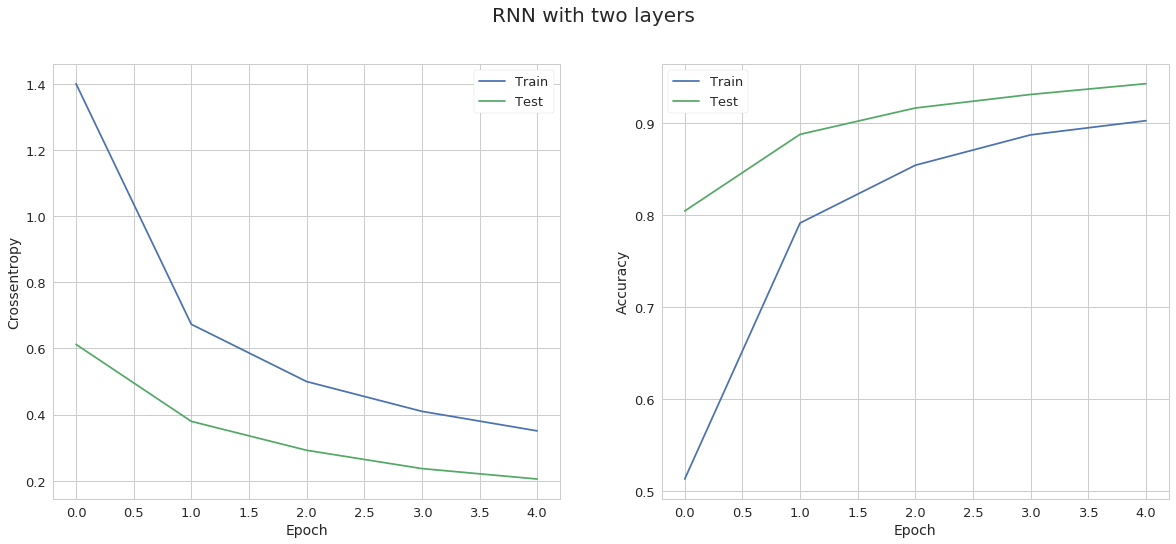

In [41]:
plt.figure(figsize=(20, 8))
plt.suptitle("RNN with two layers", fontsize=20)

plt.subplot(121)
plt.plot(hist_column_twolayers.history["loss"], label="Train")
plt.plot(hist_column_twolayers.history["val_loss"], label="Test")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Crossentropy", fontsize=14)
plt.legend()

plt.subplot(122)
plt.plot(hist_column_twolayers.history["acc"], label="Train")
plt.plot(hist_column_twolayers.history["val_acc"], label="Test")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend();

Final evaluation of the model:

In [42]:
score_train = model_column_twolayers.evaluate(X_train, y_train, verbose=0)
score_test = model_column_twolayers.evaluate(X_test, y_test, verbose=0)

In [43]:
results.loc[len(results)] = np.array([np.round(score_train[1] * 100, 2), 
                                      np.round(score_test[1] * 100, 2), 
                                      np.round(score_train[0], 3), 
                                      np.round(score_test[0], 3), 
                                      np.round(end_time_column_twolayers - start_time_column_twolayers, 1)])
results.index = ["MLP", "LSTM 1L", "LSTM 2L"]

In [44]:
results

,"Accuracy Train, %","Accuracy Test, %",Loss Train,Loss Test,"Time, s"
MLP,97.05,96.54,0.101,0.122,12.9
LSTM 1L,89.93,90.00,0.330,0.325,136.0
LSTM 2L,93.99,94.26,0.205,0.205,227.9


## Bidirectional LSTM

In many applications it makes sense to look onto the sequence in the reverse order. For example in machine translation. First output word should correspond to the first word in the initial sentence. But if we feed input sequence in the straight order than the initial first word actually becomes the first one fed into the model and thus the most distant one at the moment of generation start. So it"s reasonable to feed the initial sentence into the reverse order.

Let"s apply the same paradigm here. There is a special wrapper called `Bidirectional` for that in Keras.

In [45]:
inp = Input(shape=(img_cols, img_rows))

`Biderectional` creates layer with twice number of units specified in the internal layer (here we have LSTM with 8 units thus final bidirectional layer will have 16). Then it splits all the units into two groups:
* Half of the units are given with forward order of the sequence
* Another half are given with reversed sequence

Also one can play around with the `merge_mode` which is responsible for combining the results of the forward and reversed directions. Here we"re using concatenation.

In [46]:
hid = Bidirectional(LSTM(units=8, return_sequences=True), merge_mode="concat")(inp)
hid = LSTM(units=16, return_sequences=False)(hid)

Let"s stack fully-conected classifier on top of that:

In [47]:
hid = Dense(units=32, activation="relu")(hid)
hid = Dropout(rate=0.5)(hid)
out = Dense(nb_classes, activation="softmax")(hid)

In [48]:
model_column_bidir = Model(inputs=[inp], outputs=[out])

The final layer here uses $\text{softmax}$ activation function with the number of classes. So as the output of the network we observe the probability of each class.

In [49]:
model_column_bidir.compile(loss="categorical_crossentropy", 
                           optimizer="adam", 
                           metrics=["accuracy"])

Let"s take a look at our final model now:

In [50]:
model_column_bidir.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 28, 16)            2368      
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                544       
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                330       
Total params: 5,354
Trainable params: 5,354
Non-trainable params: 0
_________________________________________________________________


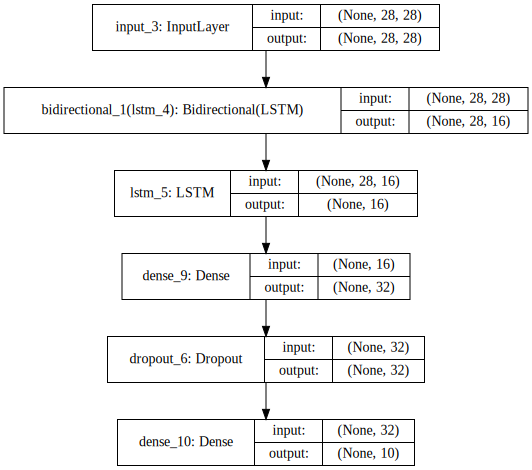

In [51]:
SVG(model_to_dot(model_column_bidir, show_shapes=True).create(prog="dot", format="svg"))

In [52]:
batch_size = 128
epochs = 5

Train!

In [53]:
%%time
start_time_column_bidir = time.time()
hist_column_bidir = model_column_bidir.fit(X_train, y_train, 
                                           batch_size=batch_size, 
                                           epochs=epochs,
                                           validation_data=(X_test, y_test))
end_time_column_bidir = time.time()

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 65s - loss: 1.5221 - acc: 0.4567 - val_loss: 0.8105 - val_acc: 0.7498
Epoch 2/5
60000/60000 [==============================] - 64s - loss: 0.8204 - acc: 0.7258 - val_loss: 0.5104 - val_acc: 0.8496
Epoch 3/5
60000/60000 [==============================] - 64s - loss: 0.5946 - acc: 0.8244 - val_loss: 0.3616 - val_acc: 0.8940
Epoch 4/5
60000/60000 [==============================] - 64s - loss: 0.4855 - acc: 0.8662 - val_loss: 0.2975 - val_acc: 0.9106
Epoch 5/5
60000/60000 [==============================] - 63s - loss: 0.4248 - acc: 0.8849 - val_loss: 0.2580 - val_acc: 0.9237
CPU times: user 9min 34s, sys: 1min 26s, total: 11min 1s
Wall time: 5min 24s


Visualization of learning process:

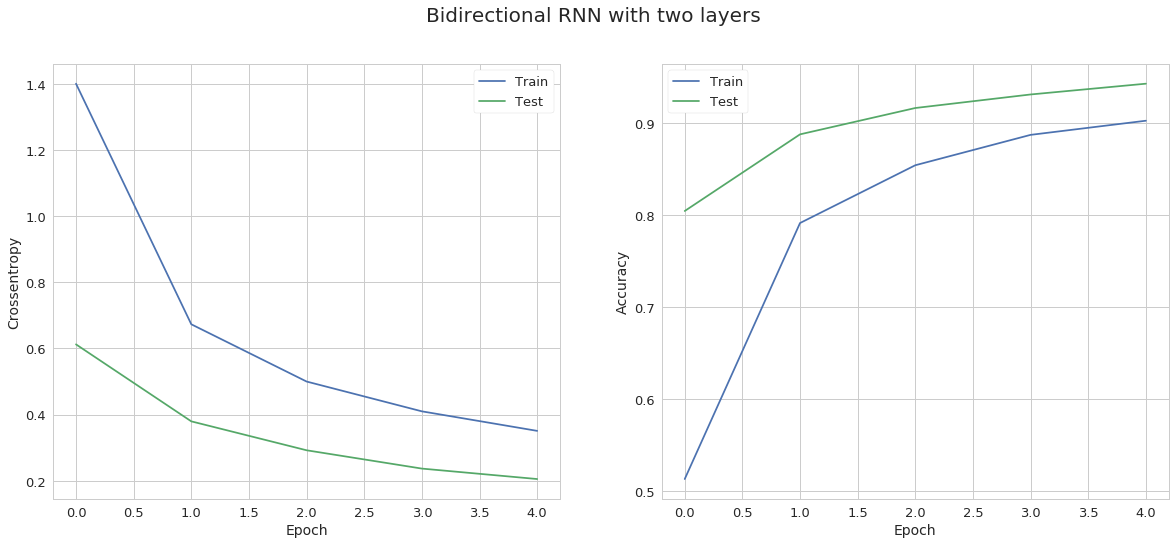

In [54]:
plt.figure(figsize=(20, 8))
plt.suptitle("Bidirectional RNN with two layers", fontsize=20)

plt.subplot(121)
plt.plot(hist_column_twolayers.history["loss"], label="Train")
plt.plot(hist_column_twolayers.history["val_loss"], label="Test")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Crossentropy", fontsize=14)
plt.legend()

plt.subplot(122)
plt.plot(hist_column_twolayers.history["acc"], label="Train")
plt.plot(hist_column_twolayers.history["val_acc"], label="Test")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend();

Final evaluation of the model:

In [55]:
score_train = model_column_bidir.evaluate(X_train, y_train, verbose=0)
score_test = model_column_bidir.evaluate(X_test, y_test, verbose=0)

In [56]:
results.loc[len(results)] = np.array([np.round(score_train[1] * 100, 2), 
                                      np.round(score_test[1] * 100, 2), 
                                      np.round(score_train[0], 3), 
                                      np.round(score_test[0], 3), 
                                      np.round(end_time_column_bidir - start_time_column_bidir, 1)])
results.index = ["MLP", "LSTM 1L", "LSTM 2L", "BiLSTM 2L"]

In [57]:
results

,"Accuracy Train, %","Accuracy Test, %",Loss Train,Loss Test,"Time, s"
MLP,97.05,96.54,0.101,0.122,12.9
LSTM 1L,89.93,90.00,0.330,0.325,136.0
LSTM 2L,93.99,94.26,0.205,0.205,227.9
BiLSTM 2L,92.51,92.37,0.262,0.258,324.8


## TASK 1: Vertical and Horizontal LSTMs

In Bidirectional LSTM approach we scanned through the same sequence of columns from different ends (from left to right and the opposite direction). Why don"t we try to scan in two different directions:
* from left to right
* from top to bottom

Try to implement this idea using functional Keras API:
* Create two branches of the network each one with its own input. 
* One (*horizontal*) input will be a left-to-right sequence of columns and other (*vertical*) will be top-to-bottom sequence of rows. 
* After passing them through the corresponding first LSTM layers use Merge layer to concatenate the output vectors. 
* Apply one more LSTM layer on top of the concatenated representations.

# Pixelwise Recurrent model

Before we treated columns as timesteps.

We can approach this problem from the different angle. Let"s flatten all our images and treat the resulting $28 \times 28 = 784$ dimensional vector as a sequence of pixels.

Let"s then apply bidirectional approach to these sequence

In [58]:
inp = Input(shape=(img_cols * img_rows, 1))

In [59]:
hid = Bidirectional(LSTM(units=8, return_sequences=True), merge_mode="concat")(inp)
hid = LSTM(units=16, return_sequences=False)(hid)

Let"s stack fully-conected classifier on top of that:

In [60]:
hid = Dense(units=32, activation="relu")(hid)
hid = Dropout(rate=0.5)(hid)
out = Dense(nb_classes, activation="softmax")(hid)

In [61]:
model_pixel_bidir = Model(inputs=[inp], outputs=[out])

The final layer here uses $\text{softmax}$ activation function with the number of classes. So as the output of the network we observe the probability of each class.

In [62]:
model_pixel_bidir.compile(loss="categorical_crossentropy", 
                          optimizer="adam", 
                          metrics=["accuracy"])

Let"s take a look at our final model now:

In [63]:
model_pixel_bidir.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 784, 1)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 784, 16)           640       
_________________________________________________________________
lstm_7 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_11 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                330       
Total params: 3,626
Trainable params: 3,626
Non-trainable params: 0
_________________________________________________________________


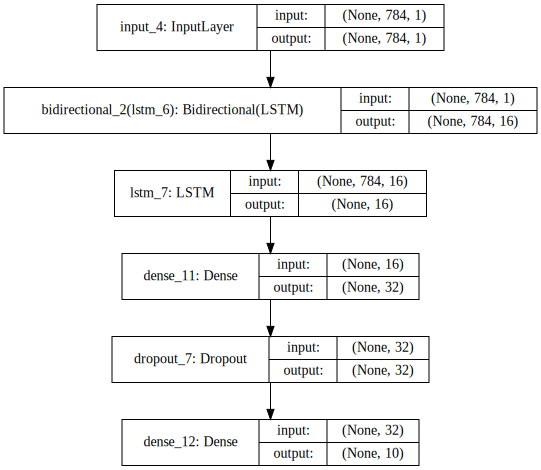

In [64]:
SVG(model_to_dot(model_pixel_bidir, show_shapes=True).create(prog="dot", format="svg"))

Sequences are extremely long (784 timesteps) thus even one epoch of the training takes too much time. So let"s try it for one epoch

In [65]:
batch_size = 128
epochs = 1

Train!

In [66]:
%%time
start_time_pixel_bidir = time.time()
hist_pixel_bidir = model_pixel_bidir.fit(X_train.reshape(-1, img_cols * img_rows, 1), y_train, 
                                         batch_size=batch_size, 
                                         epochs=epochs,
                                         validation_data=(X_test.reshape(-1, img_cols * img_rows, 1), y_test))
end_time_pixel_bidir = time.time()

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 1329s - loss: 2.0259 - acc: 0.2182 - val_loss: 1.7900 - val_acc: 0.3011
CPU times: user 37min 42s, sys: 5min 51s, total: 43min 33s
Wall time: 22min 11s


Final evaluation of the model:

In [67]:
score_train = model_pixel_bidir.evaluate(X_train.reshape(-1, img_cols * img_rows, 1), y_train, verbose=1)
score_test = model_pixel_bidir.evaluate(X_test.reshape(-1, img_cols * img_rows, 1), y_test, verbose=1)

10000/10000 [==============================] - 169s   


In [76]:
results.loc[len(results)] = np.array([np.round(score_train[1] * 100, 2), 
                                      np.round(score_test[1] * 100, 2), 
                                      np.round(score_train[0], 3), 
                                      np.round(score_test[0], 3), 
                                      np.round(end_time_pixel_bidir - start_time_pixel_bidir, 1)])
results.index = ["MLP", "LSTM 1L", "LSTM 2L", "BiLSTM 2L", "Pixel BiLSTM 2L (1 epoch)"]

In [77]:
results

,"Accuracy Train, %","Accuracy Test, %",Loss Train,Loss Test,"Time, s"
MLP,97.05,96.54,0.101,0.122,12.9
LSTM 1L,89.93,90.00,0.330,0.325,136.0
LSTM 2L,93.99,94.26,0.205,0.205,227.9
BiLSTM 2L,92.51,92.37,0.262,0.258,324.8
Pixel BiLSTM 2L (1 epoch),30.73,30.11,1.781,1.790,1331.5


# CNN + RNN

As one can see pixelwise approach might be well but we can not train it properly because of the enormous sequence length. The essential solution is to reduce the dimensionality of the initial data before flattening. There are plenty of methods to do it:
* PCA
* Autoencoder
* CNN

Here we"re going to use CNNs that are available in Keras. Thus we will be able to do everything inside one pipiline and train our model in end-to-end manner.

In [78]:
inp = Input(shape=(img_cols, img_rows, 1))

First of all, let"s apply one simple convolutional block to the initial image. It consists of two consecutive convolutional layer and max pooling layer on top of them. The only parameter that can be unclear here is `padding="valid"`. It means that we"re not going to pad our image with zeros after convolution (the spatial size of the image will be changing).

In [79]:
cnn = Convolution2D(filters=32, 
                    kernel_size=(3, 3),
                    padding="valid", 
                    activation="relu")(inp)
cnn = Convolution2D(filters=32, 
                    kernel_size=(3, 3),
                    padding="valid", 
                    activation="relu")(cnn)
cnn = MaxPooling2D(pool_size=(2, 2))(cnn)

Let"s apply the same block one more time to further reduce dimensionality

In [80]:
cnn = Convolution2D(filters=32, 
                    kernel_size=(3, 3),
                    padding="valid", 
                    activation="relu")(cnn)
cnn = Convolution2D(filters=32, 
                    kernel_size=(3, 3),
                    padding="valid", 
                    activation="relu")(cnn)
cnn = MaxPooling2D(pool_size=(2, 2))(cnn)

At this point we have 32-channel output image. Now we"re going to collapse all 32 channels into 1. For this purpose we"re going to use **1x1 convolutions**. 

Technically, the 1x1 convolutional filter behaves exactly the same as “normal” filters. The only confused thing is the size 1x1 of the filter which indicates that the filter does not care at all about the correlation of information in the same feature map. Which mean, there is no visual pattern being learned in here. Instead, the filter pools the information across multi feature maps. The size of the kernel actually is 1x1xk where k is the number of feature maps. This is one way to compress these feature maps into one (or you can think of it as dimension reduction).

Such kind of layers were introduced in [this](https://arxiv.org/pdf/1312.4400v3.pdf) paper and are used in, e.g, GoogLeNet [architecture](https://arxiv.org/pdf/1409.4842v1.pdf). For more detailed explanation one can also look [here](http://iamaaditya.github.io/2016/03/one-by-one-convolution/)

In [81]:
cnn = Convolution2D(filters=1, 
                    kernel_size=(1, 1))(cnn)

After that we need to make the sequence out of 1 remained feature map. It can be done with `Reshape` layer.

In [82]:
cnn = Reshape((-1, 1))(cnn)

Now let"s come back to our pixelwise LSTM idea

In [83]:
rnn = Bidirectional(LSTM(units=8, return_sequences=True), merge_mode="concat")(cnn)
rnn = LSTM(units=16, return_sequences=False)(rnn)

Let"s stack fully-conected classifier on top of that:

In [84]:
hid = Dense(units=32, activation="relu")(rnn)
hid = Dropout(rate=0.5)(hid)
out = Dense(nb_classes, activation="softmax")(hid)

In [85]:
model_cnn_rnn_bidir = Model(inputs=[inp], outputs=[out])

The final layer here uses $\text{softmax}$ activation function with the number of classes. So as the output of the network we observe the probability of each class.

In [86]:
model_cnn_rnn_bidir.compile(loss="categorical_crossentropy", 
                            optimizer="adam", 
                            metrics=["accuracy"])

Let"s take a look at our final model now:

In [87]:
model_cnn_rnn_bidir.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
__________

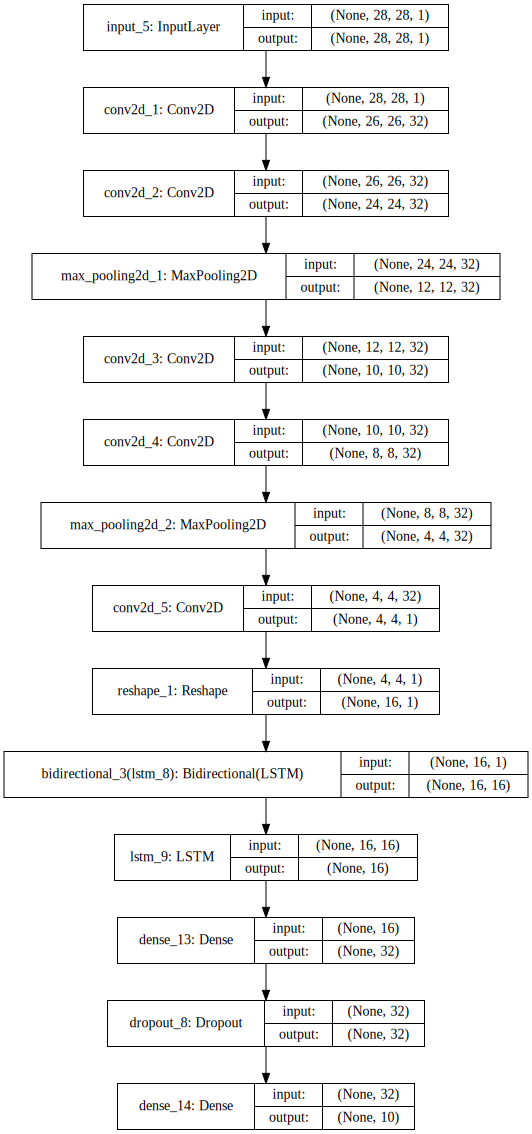

In [88]:
SVG(model_to_dot(model_cnn_rnn_bidir, show_shapes=True).create(prog="dot", format="svg"))

Sequences now are much shorter: only 16 steps long! That"s what we want!

In [89]:
batch_size = 128
epochs = 5

Train!

In [90]:
%%time
start_time_cnn_rnn_bidir = time.time()
hist_cnn_rnn_bidir = model_cnn_rnn_bidir.fit(X_train.reshape(-1, img_rows, img_cols, 1), y_train, 
                                             batch_size=batch_size, 
                                             epochs=epochs,
                                             validation_data=(X_test.reshape(-1, img_rows, img_cols, 1), y_test))
end_time_cnn_rnn_bidir = time.time()

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 46s - loss: 1.3442 - acc: 0.5234 - val_loss: 0.4506 - val_acc: 0.8737
Epoch 2/5
60000/60000 [==============================] - 39s - loss: 0.5460 - acc: 0.8571 - val_loss: 0.2704 - val_acc: 0.9272
Epoch 3/5
60000/60000 [==============================] - 38s - loss: 0.4125 - acc: 0.8960 - val_loss: 0.2014 - val_acc: 0.9451
Epoch 4/5
60000/60000 [==============================] - 45s - loss: 0.3323 - acc: 0.9176 - val_loss: 0.1848 - val_acc: 0.9519
Epoch 5/5
60000/60000 [==============================] - 45s - loss: 0.2853 - acc: 0.9277 - val_loss: 0.1519 - val_acc: 0.9574
CPU times: user 5min 58s, sys: 54.4 s, total: 6min 52s
Wall time: 3min 36s


Visualization of learning process:

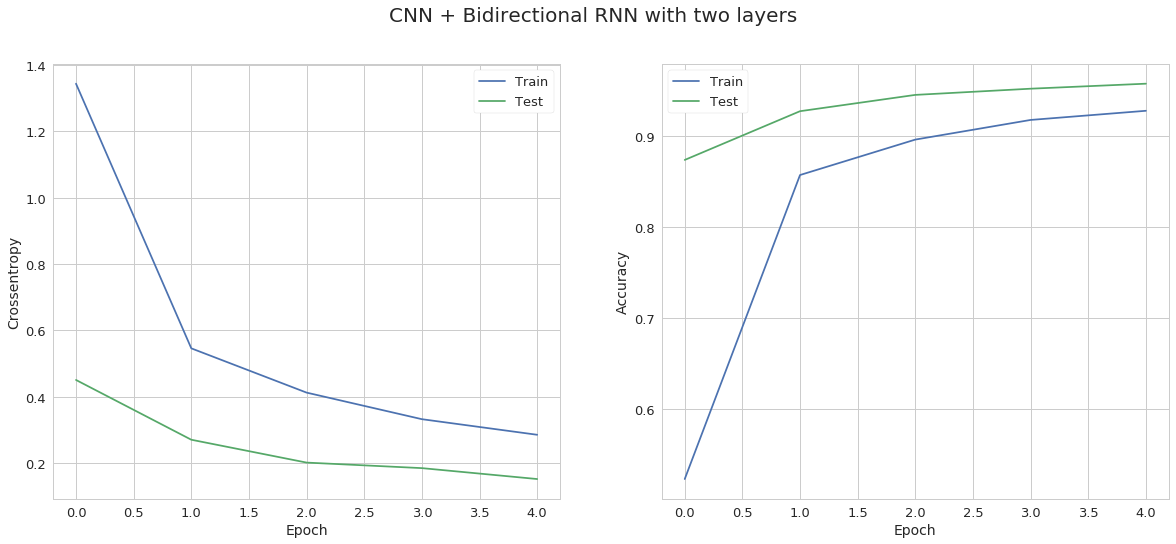

In [91]:
plt.figure(figsize=(20, 8))
plt.suptitle("CNN + Bidirectional RNN with two layers", fontsize=20)

plt.subplot(121)
plt.plot(hist_cnn_rnn_bidir.history["loss"], label="Train")
plt.plot(hist_cnn_rnn_bidir.history["val_loss"], label="Test")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Crossentropy", fontsize=14)
plt.legend()

plt.subplot(122)
plt.plot(hist_cnn_rnn_bidir.history["acc"], label="Train")
plt.plot(hist_cnn_rnn_bidir.history["val_acc"], label="Test")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend();

Final evaluation of the model:

In [92]:
score_train = model_cnn_rnn_bidir.evaluate(X_train.reshape(-1, img_rows, img_cols, 1), y_train, verbose=1)
score_test = model_cnn_rnn_bidir.evaluate(X_test.reshape(-1, img_rows, img_cols, 1), y_test, verbose=1)

 9952/10000 [============================>.] - ETA: 0s

In [93]:
results.loc[len(results)] = np.array([np.round(score_train[1] * 100, 2), 
                                      np.round(score_test[1] * 100, 2), 
                                      np.round(score_train[0], 3), 
                                      np.round(score_test[0], 3), 
                                      np.round(end_time_cnn_rnn_bidir - start_time_cnn_rnn_bidir, 1)])
results.index = ["MLP", "LSTM 1L", "LSTM 2L", "BiLSTM 2L", "Pixel BiLSTM 2L (1 epoch)", "CNN + BiLSTM 2L"]

In [94]:
results

,"Accuracy Train, %","Accuracy Test, %",Loss Train,Loss Test,"Time, s"
MLP,97.05,96.54,0.101,0.122,12.9
LSTM 1L,89.93,90.00,0.330,0.325,136.0
LSTM 2L,93.99,94.26,0.205,0.205,227.9
BiLSTM 2L,92.51,92.37,0.262,0.258,324.8
Pixel BiLSTM 2L (1 epoch),30.73,30.11,1.781,1.790,1331.5
CNN + BiLSTM 2L,95.66,95.74,0.159,0.152,216.8


# TASK 2: Tune hyperparameters
Here we run all the models with the same number of epochs (5) and the same batch size (128). For fully-connected model it might be ok but LSTMs need definitely more epochs to train properly. That is one of the reasons that LSTMs perform worse than Dense model in our table of comparison. Try to tune the hyperparameters of the models to achieve better quality. Which of the approaches benefit more?

# TASK 3: CIFAR10
Repeat the method from this notebook for CIFAR10 dataset and see what the results are.